In [1]:
from shapely.geometry import MultiPolygon, Polygon

import pandas as pd
import geopandas as gpd
import numpy as np

import datetime

from matplotlib import pyplot as plt

import requests
import arrow

import sys
sys.path.append('/home/jovyan/python-helper/src/')

from loggers import TimeEstimator
from branca.colormap import LinearColormap

from matplotlib.colors import LinearSegmentedColormap

from kalmanutils import interpolate_perimeter, get_vertices, calculate_vectors, align_perimeters, calculate_uncertainties_observed, calculate_modified

%load_ext autoreload
%autoreload 2

In [2]:
def change_username_to_jovyan(df, column):

    for ix, row in df.iterrows():
        path_list = row['filepath'].split('/')
        path_list[2] = 'jovyan'

        path = ''
        for string in path_list[:-1]:
            path += f'{string}/'
        path += path_list[-1]

        df.loc[ix, column] = path

def plot_perimeter(vertices, ax, **kwargs):
    ax.plot(np.array(vertices)[:,0], 
            np.array(vertices)[:,1], **kwargs)
    
    # if dx == None:
    #     ax.plot(vertices[ix][0], vertices[ix][1], color+'o')
    # else:
    #     for i in np.arange(0, len(vertices), dx):
    #         ax.plot(vertices[i][0], vertices[i][1], color+'o')

In [3]:
gdfMariaSim = pd.read_pickle('~/farsite-devAPI/src/Maria2019_simulation.pkl')
change_username_to_jovyan(gdfMariaSim, 'filepath')
change_username_to_jovyan(gdfMariaSim, 'configpath')

df = pd.read_pickle('~/data/test_table.pkl')
dfMaria = df[(df['description'] == 'Maria2019') & 
             (df['filetype'] == 'Ignition')]
change_username_to_jovyan(dfMaria, 'filepath')

for ix, row in dfMaria.iterrows():
    if isinstance(gpd.read_file(row['filepath'])['geometry'].iloc[0], MultiPolygon):
        dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0].geoms[0]
    elif isinstance(gpd.read_file(row['filepath'])['geometry'].iloc[0], Polygon):
        dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0]
    else:
        print('type is not Polygon or MultiPolygon. Check!!')
        break
gdfMariaIgnition = gpd.GeoDataFrame(dfMaria, crs='EPSG:5070', geometry='geometry')

/tmp/ipykernel_64/695479770.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[ix, column] = path
/tmp/ipykernel_64/885252770.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0]


In [4]:
#0- Get vertices

igidx = 0
obidx = 1
nextobidx = 2
simidx = 584

ignition = get_vertices(gdfMariaIgnition.iloc[igidx]['geometry'])
observe = get_vertices(gdfMariaIgnition.iloc[obidx]['geometry'])
next_observe = get_vertices(gdfMariaIgnition.iloc[nextobidx]['geometry'])
model = get_vertices(gdfMariaSim.iloc[simidx]['geometry'])

In [5]:
#1- Rotate & align each vertices after interpolation
ignition_aligned, observe_aligned, next_observe_aligned, model_aligned = align_perimeters([ignition, observe, next_observe, model])

#2 Calculate uncertainties in observe
winddirection = gdfMariaSim.iloc[simidx]['winddirection']
print(f'winddirection: {winddirection}')
observed_uncertainties = calculate_uncertainties_observed(observe_aligned, winddirection)
next_observed_uncertainties = calculate_uncertainties_observed(next_observe_aligned, winddirection)

dt = 20

ignition_aligned = np.array(ignition_aligned)
observe_aligned = np.array(observe_aligned) 
next_observe_aligned = np.array(next_observe_aligned)
model_aligned = np.array(model_aligned)
observed_uncertainties = np.array(observed_uncertainties)
observed_velocity_aligned = (observe_aligned - ignition_aligned) / dt

model_velocity_aligned = (model_aligned - ignition_aligned) / dt

next_observed_uncertainties = np.array(next_observed_uncertainties)
next_observed_velocity_aligned = (next_observe_aligned - model_aligned) / dt


# fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
# plot_perimeter(ignition_aligned, ax)
# plot_perimeter(observe_aligned, ax)
# plot_perimeter(next_observe_aligned, ax)
# plot_perimeter(model_aligned, ax, ls='--')

winddirection: 90.0


In [6]:
# ignition_aligned_1d = np.array(ignition_aligned).flatten()
# observe_aligned_1d = np.array(observe_aligned).flatten()    # x_measure
# model_aligned_1d = np.array(model_aligned).flatten()        # x_prediction
# observed_uncertainties_1d = observed_uncertainties.repeat(2) # observation errors

# dt = 20 # in minutes
len(observe_aligned)

465

## Apply Linear Kalman Filter without acceleration

In [8]:
# Process errors initially
dpx0 = 0.1
dpvx0 = 0.1
dpy0 = 0.1
dpvy0 = 0.1

# Process error
P_kneg = [np.array([dpx0*dpx0, 0, 0, 0], 
                      [0, dpvx0*dpvx0, 0, 0],
                      [0, 0, dpy0*dpy0, 0],
                      [0, 0, 0, dpvy0*dpvy0])]*len(observe_aligned)

modified_vertices = calculate_modified(observe_aligned, observed_velocity_aligned, observed_uncertainties,
                                       next_observe_aligned, next_observed_velocity_aligned, P_kneg)

geom = Polygon(shell=(modified_vertices)).buffer(0)

# TODO: modified vertices need to be reordered
# 1. A better data structure for the points to keep track of the relative position
# Idea: 
# a) As new vertex is calculated, find the closest two points, then insert into the position while keeping the clockwise order

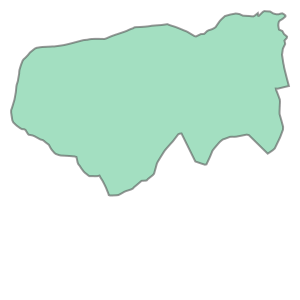

Text(0, 0.5, 'North-South (m)')

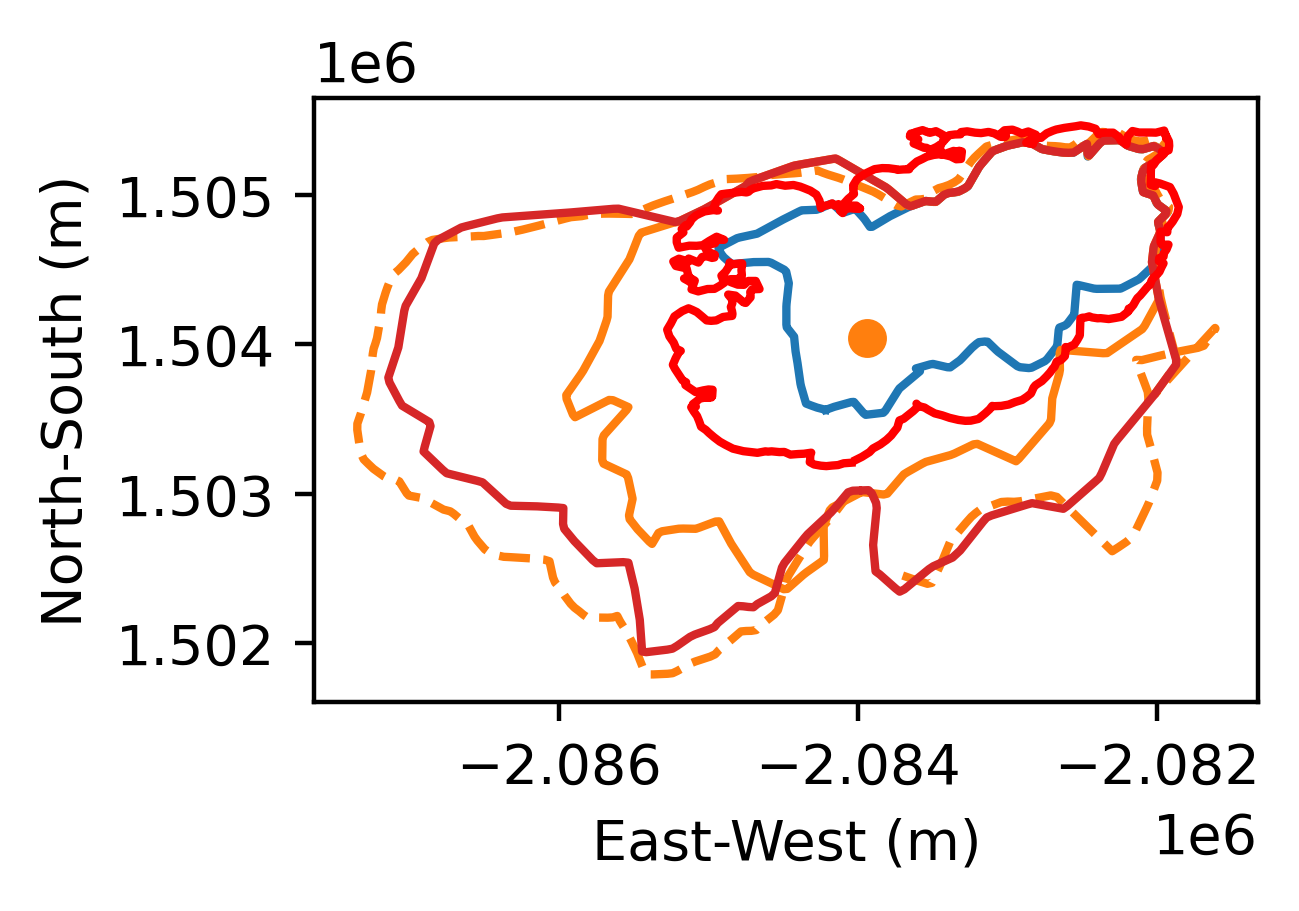

In [9]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=400)

plot_perimeter(ignition_aligned, ax=ax)
plot_perimeter(modified_vertices, ax=ax, ls='--')
plot_perimeter(observe_aligned, ax=ax, color='tab:orange')
plot_perimeter(next_observe_aligned, ax=ax, color='tab:red')
plot_perimeter(model_aligned, color='red', ax=ax)
ax.plot(np.mean(observe_aligned, axis=0)[0], np.mean(observe_aligned, axis=0)[1], 'o', color='tab:orange')

ax.set_aspect(1)
    
# xlim = (-2086157.8176353823, -2081650.1039221247)
# ylim = (1502205.458511021, 1505619.1686423323)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

ax.set_xlabel('East-West (m)')
ax.set_ylabel('North-South (m)')

Text(0, 0.5, 'North-South (m)')

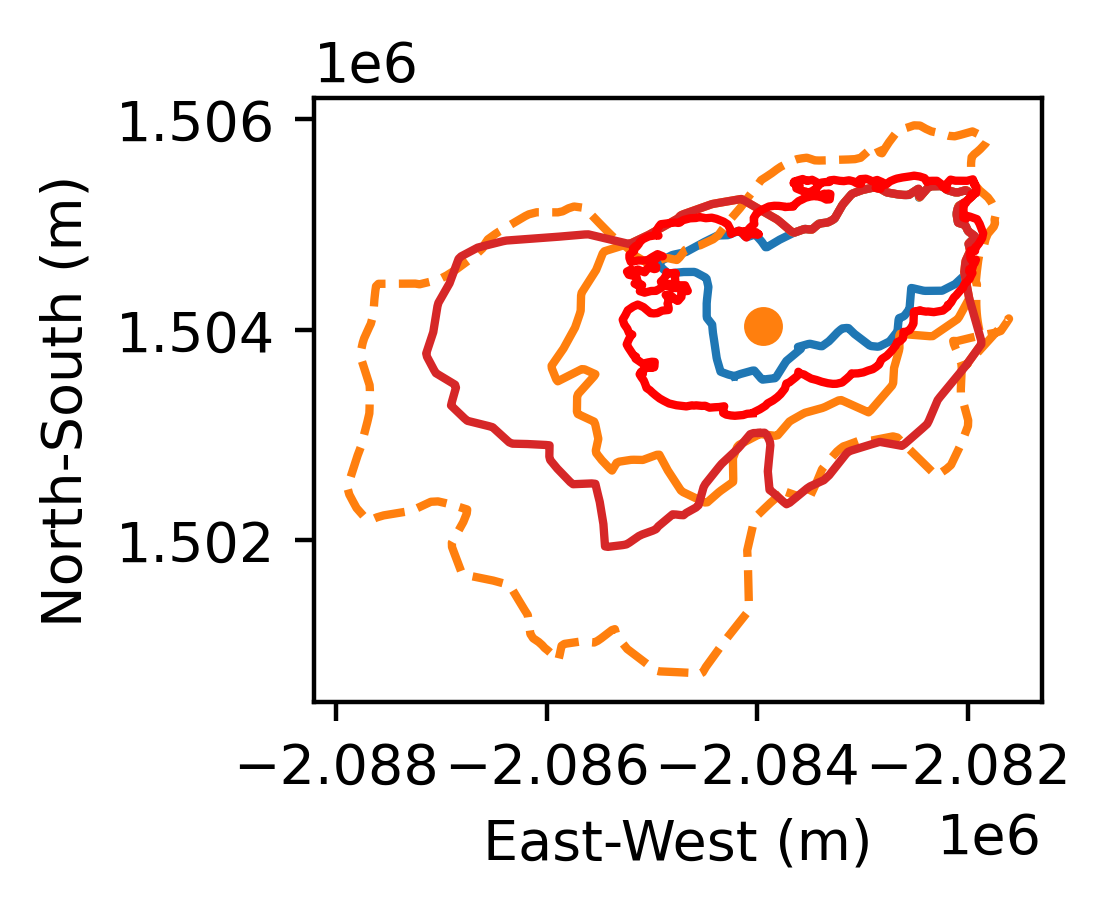

In [21]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=400)

plot_perimeter(ignition_aligned, ax=ax)
plot_perimeter(modified_vertices, ax=ax, ls='--')
plot_perimeter(observe_aligned, ax=ax, color='tab:orange')
plot_perimeter(next_observe_aligned, ax=ax, color='tab:red')
plot_perimeter(model_aligned, color='red', ax=ax)
ax.plot(np.mean(observe_aligned, axis=0)[0], np.mean(observe_aligned, axis=0)[1], 'o', color='tab:orange')

ax.set_aspect(1)
    
# xlim = (-2086157.8176353823, -2081650.1039221247)
# ylim = (1502205.458511021, 1505619.1686423323)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

ax.set_xlabel('East-West (m)')
ax.set_ylabel('North-South (m)')

In [121]:
obix = 1
modix = 405

geom_observe = gdfMariaIgnition.iloc[obix]['geometry']
geom_model = gdfMariaSim.iloc[modix]['geometry']
winddirection = gdfMariaSim.iloc[modix]['winddirection']
windspeed = gdfMariaSim.iloc[modix]['windspeed']

In [122]:
da = DataAssimilation(geom_observe, geom_model)

In [134]:
da.calculate_uncertainties_observed(winddirection)

In [ ]:


def calculate_uncertainties(vectors_lst, winddirection, scale=1000):
    uncertainties_lst = []
    for vectors in vectors_lst:
        uncertainties_lst.append(observed_uncertainties(vectors, winddirection, scale))
        
    return uncertainties_lst
##################################################

##################################################
####  WX DATA Uncertainties ######################
##################################################
def collect_wx_data(centroid, fromdt, todt):
    km_per_miles = 1.60934
    
    baseURL = "https://firemap.sdsc.edu/pylaski/stations/data?"

    ## Always start with the base of the URL

    selectionType='selection=withinRadius'

    # Choose the centroid of the ignition
    lon = centroid.x
    lat = centroid.y
    radius = 5*km_per_miles    # 2 mile radius

    ## Latitude and longitude of the White House according to Google
    selectionParameters = '&lat={}&lon={}&radius={}'.format(str(lat),str(lon), str(radius))

    observables_list = ['temperature', 'wind_speed', 'wind_direction']
    observables = ''
    for observable in observables_list:
        observables += f'&observable={observable}'

#     fromdt = ignite['datetime'].tz_localize('US/Pacific')
#     todt = compare['datetime'].tz_localize('US/Pacific')
    frm = arrow.Arrow.fromdatetime(fromdt.to_pydatetime())
    to = arrow.Arrow.fromdatetime(todt.to_pydatetime())

    frm = frm.shift(minutes=-10)
    to = to.shift(minutes=10)

    urlDateTime = '&from={}&to={}'.format(str(frm), str(to))

    urlPlot = baseURL + selectionType + selectionParameters + observables + urlDateTime
    print(urlPlot)

    r = requests.get(urlPlot)
    ## Request to GET information from the given URL (Our REST query we built)
    return r.json()

def calculate_indices(x, edge_value, bin_counts):
    xix = ((x + edge_value)/(2*edge_value/bin_counts)).astype(int)
    xix[xix>=bin_counts] = bin_counts-1
    xix[xix<0] = 0
    
    return xix

def calculate_binned_winds(x, y, weights, edge_value, bin_counts):
    xix = calculate_indices(x, edge_value, bin_counts)
    yix = calculate_indices(y, edge_value, bin_counts)

    XY = np.zeros((bin_counts, bin_counts))
    for i,j, weight in zip(xix, yix, weights):
        XY[i,j] += weight

    return XY
##################################################
##################################################

# def convolve_timeseries(times, values, hours=6):
#     if np.unique(np.diff(times)).size > 1:
#         print('Variable time interval is given! This is not yet implemented!')

#     # Calculate the kernel size from the fixed time difference
#     dt = times[1]-times[0]
#     kernel_size = int(hours*3600/dt.total_seconds())
#     if kernel_size%2 == 0:  # Make kernel size an odd number
#         kernel_size += 1
        
    
#     # Calculate the convolution:
#     convolved_values = np.convolve(values, np.ones(kernel_size), mode='valid')/kernel_size
#     clip_index = int((kernel_size-1)/2)
#     time_clipped = times[clip_index:-clip_index]
    
    
#     return time_clipped, convolved_values, clip_index

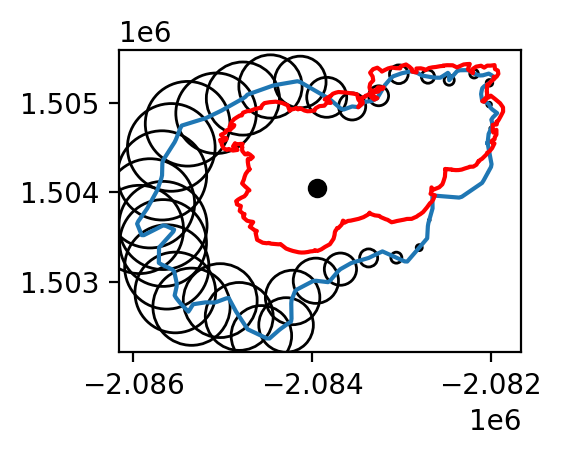

In [135]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)


for ix, uncertainty in enumerate(da.uncertainties_observe):
    if ix%10 == 0:
        x = da.vertices_observe[ix][0]
        y = da.vertices_observe[ix][1]
        circle = plt.Circle((x, y), uncertainty*1000, fill=False)

        ax.add_artist(circle)

plot_perimeter(da.vertices_observe, ax=ax)
plot_perimeter(da.vertices_model, color='red', ax=ax)
ax.plot(np.mean(da.vertices_observe, axis=0)[0], np.mean(da.vertices_observe, axis=0)[1], 'ko')
ax.set_aspect(1)
    

In [ ]:
gdfMariaSim = pd.read_pickle('~/farsite-devAPI/src/Maria2019_simulation.pkl')
change_username_to_jovyan(gdfMariaSim, 'filepath')
change_username_to_jovyan(gdfMariaSim, 'configpath')

df = pd.read_pickle('~/data/test_table.pkl')
dfMaria = df[(df['description'] == 'Maria2019') & 
             (df['filetype'] == 'Ignition')]
change_username_to_jovyan(dfMaria, 'filepath')

for ix, row in dfMaria.iterrows():
    if isinstance(gpd.read_file(row['filepath'])['geometry'].iloc[0], MultiPolygon):
        dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0].geoms[0]
    elif isinstance(gpd.read_file(row['filepath'])['geometry'].iloc[0], Polygon):
        dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0]
    else:
        print('type is not Polygon or MultiPolygon. Check!!')
        break
gdfMariaIgnition = gpd.GeoDataFrame(dfMaria, crs='EPSG:5070', geometry='geometry')

In [ ]:
winddirection = 50

vertices_lst = list(gdfMariaIgnition['geometry'].exterior.apply(lambda row: list(row.coords)).values)
rotated_vertices_lst = align_perimeters(vertices_lst)
trajectories_lst = calculate_trajectories(rotated_vertices_lst)
vectors_lst = calculate_vectors(rotated_vertices_lst)
uncertainties_lst = calculate_uncertainties(vectors_lst, winddirection, scale=120)

In [ ]:
gdf

In [ ]:
cm = LinearColormap(colors=[(255,128,128,255), (255,0,0,255)])
ix = 0

fig, ax = plt.subplots(1,1,figsize=(4,2), dpi=200)
for i, vertices in enumerate(vertices_lst[:-2]):
    color = cm.rgba_hex_str(i/len(vertices_lst[:-2]))
    plot_perimeter(vertices, ax, color=color)
    # plot_perimeter(vertices[ix:ix+1], ax, marker='o')

In [ ]:
xlim = (-2091454.505641569, -2080213.0233935725)
ylim = (1500625.682860173, 1507596.7094396015)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
plot_perimeter(vertices_lst[0], ax, color='b',marker='o', markersize=5, linestyle='')
plot_perimeter(rotated_vertices_lst[0], ax, linestyle='-', linewidth=1.5, color='r')

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

In [ ]:
number_of_vertices = []
for vertices in vertices_lst:
    number_of_vertices.append(len(vertices))

fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
ax.plot(gdfMariaIgnition['datetime'].iloc[:-2], number_of_vertices[:-2])
ax.tick_params(axis='x', labelrotation=45)

ax.set_ylabel('Number of vertices')
ax.set_xlabel('Date of observation')

ax.set_yticks(np.arange(0,750,100))
ax.set_ylim(0,550)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
plot_perimeter(rotated_vertices_lst[0], ax)
for i in range(len(uncertainties_lst[0])):
    if i%10 == 0:
        ax.plot(rotated_vertices_lst[0][i][0] ,rotated_vertices_lst[0][i][1], 'o', 
                markersize=uncertainties_lst[0][i], color=(0,0,0,0.3))

In [ ]:
gdfMariaKalman = pd.read_pickle('./Maria2019_simulation_Kalman_1.pkl')
gdfMariaKalman

In [ ]:
gdfMariaIgnition.loc['9f82e870591748a9a8a01346d174f2a1']

In [ ]:
uncertain

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

ix = 80
uix = 0

dx = None

# test_vertices = list(gdfMariaIgnition.loc['9f82e870591748a9a8a01346d174f2a1', 'geometry'].exterior.coords)
colors = 'rcmyb'
plot_perimeter(rotated_vertices_lst[0], ax, color=colors[0])
plot_perimeter(rotated_vertices_lst[1], ax, color=colors[1])
# plot_perimeter(test_vertices, ax, 'k', 0, None)
plot_perimeter(rotated_vertices_lst[2], ax, color=colors[2])
plot_perimeter(rotated_vertices_lst[3], ax, color=colors[3])
plot_perimeter(rotated_vertices_lst[4], ax, color=colors[4])
# plot_perimeter(rotated_vertices_lst[5], ax, 'r', ix, dx)
# plot_perimeter(rotated_vertices_lst[6], ax, 'c', ix, dx)
# plot_perimeter(rotated_vertices_lst[7], ax, 'm', ix, dx)
# plot_perimeter(rotated_vertices_lst[8], ax, 'y', ix, dx)

centroid = np.array(rotated_vertices_lst[uix]).mean(axis=0)
ax.plot(centroid[0], centroid[1], 'ko')

trajectories_lst = calculate_trajectories(rotated_vertices_lst)
traj = np.array(trajectories_lst[ix])
ax.plot(traj[:5,0], traj[:5,1], 'k--')

for i, (tx, ty) in enumerate(traj[:5,:]):
    ax.plot(tx, ty, 'o',  markersize=uncertainties_lst[i][ix]/2, color=colors[i], fillstyle='none')


# for i in range(len(uncertainties_lst[uix])):
#     if i%35 == 0:
#         ax.plot(rotated_vertices_lst[uix][i][0] ,rotated_vertices_lst[uix][i][1], 'o', 
#                 markersize=uncertainties_lst[uix][i]/2, color=(0,0,0,1), fillstyle='none')
        
# gdf = gdfMariaKalman
gdf = gdfMariaSim[(gdfMariaSim['igniteidx'] == 'f23196b034474744bdca7df94b13e0f7') & 
                  (gdfMariaSim['winddirection'] == 50) &
                  (gdfMariaSim['windspeed'] == 15)]

# Plot the predictions
for gix, gdfrow in gdf.iterrows():
    geom = gdfrow['geometry']
    
    if isinstance(geom, MultiPolygon):
        geom = geom.geoms[0]
    
    vertices = list(geom.exterior.coords)
    # plot_perimeter(vertices, ax, color='r')
    
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

In [ ]:
N = max(number_of_vertices)
interpolated_vertices = interpolate_perimeter(vertices, N)

In [ ]:
xlim

In [ ]:
gdfMariaIgnition

In [ ]:
%%time

compareidx = '9f82e870591748a9a8a01346d174f2a1'

vertices_observed = list(gdfMariaIgnition.loc[compareidx]['geometry'].exterior.coords)
centroid = gdfMariaIgnition.to_crs(epsg=4326).loc[compareidx, 'geometry'].centroid

fromdate = gdfMariaIgnition.loc[compareidx, 'datetime'].tz_localize('US/Pacific') - datetime.timedelta(hours=6)
todate = gdfMariaIgnition.loc[compareidx, 'datetime'].tz_localize('US/Pacific')
wxdata = collect_wx_data(centroid, fromdate, todate)

In [ ]:
station_data = []
for feature in wxdata['features']:
    name = feature['properties']['description']['name']
    wifireuid = feature['properties']['description']['wifire_uid']
    
    
    distance = feature['properties']['distanceFromLocation']
    coordinates = feature['geometry']['coordinates']
    
    times = pd.to_datetime(feature['properties']['timestamp'])
    
    units = feature['properties']['units']
    temperatures = feature['properties']['temperature']
    windspeeds = feature['properties']['wind_speed']
    winddirections = feature['properties']['wind_direction']
    
    print(f'name: {name}\ndist: {distance}')
    
    station_data.append({'name': name,
                         'time': times,
                         'windspeed': windspeeds,
                         'winddirection': winddirections,
                         'temperature': temperatures,
                         'units': units,
                         'coordinates': coordinates,
                         'distance': distance,
                         'wifireuid': wifireuid})
    

In [ ]:
df = pd.DataFrame(index=times, data={'temperature': temperatures, 'windspeed': windspeeds, 'winddirection': winddirections})
df['U'] = df['windspeed']*np.cos(df['winddirection']/180*np.pi)
df['V'] = df['windspeed']*np.sin(df['winddirection']/180*np.pi)
df['hour'] = df.index.hour
df = df.sort_index()

In [ ]:
x = df.dropna()['U'].values
y = df.dropna()['V'].values
t = df.dropna().index

alpha_range = np.arange(1, len(x)+1)/len(x)
colors = []
for alpha in alpha_range:
    colors.append((0,0,1,alpha))
cmap = LinearSegmentedColormap.from_list('WhiteBlue', colors=[(1,1,1,1), (0,0,1,1)])
    
tdiff_seconds = (t - t[0]).total_seconds()
weights = tdiff_seconds/tdiff_seconds.max()
    
# plot_binned_winds(x, y, weights, 15, 51, df.iloc[-1].index.name)
edge_value = 15
bin_counts = 51
XY = calculate_binned_winds(x, y, weights, edge_value, bin_counts)
ixmax, jxmax = np.unravel_index(XY.argmax(), XY.shape)

delta = 2*edge_value/bin_counts
xmaxbin = (-edge_value + ixmax*delta, -edge_value + (ixmax+1)*delta)
ymaxbin = (-edge_value + jxmax*delta, -edge_value + (jxmax+1)*delta)


In [ ]:
xix, yix = np.where(XY>0)
xmeans = -edge_value + (xix+0.5)*delta
ymeans = -edge_value + (yix+0.5)*delta

weights = XY[xix, yix]/XY.sum()

windspeed = np.round(np.sqrt(xmeans**2 + ymeans**2)).astype(int)
winddirection = np.round(np.arctan2(ymeans, xmeans)*180/np.pi).astype(int)
winddirection[np.where(winddirection<0)[0]] += 360

In [ ]:
pd.read_pickle('./Maria2019_simulation_Kalman_1.pkl')

In [ ]:
# windspeeds = gdfMariaSim['windspeed'].unique()
# winddirections = gdfMariaSim['winddirection'].unique()

# wsidx = 10
# wdidx = 15

gdfMariaSim = pd.read_pickle('./Maria2019_simulation_Kalman_1.pkl')
idx = 10

ws = windspeed[idx]
wd = winddirection[idx]

print(f'Calculating for ws={windspeed}, wd={winddirection}')

vertices_simulated = list(gdfMariaSim[(gdfMariaSim['windspeed'] == ws) &
                                      (gdfMariaSim['winddirection'] == wd)].iloc[0]['geometry'].exterior.coords)
vertices_observed = gdfMariaIgnition.iloc[1]['geometry'].exterior.coords

vertex_pairs = find_pairs(vertices_observed, vertices_simulated)
vertex_pairs_np = np.array(vertex_pairs)

vertices_A = vertex_pairs_np[:, :2]
vertices_B = vertex_pairs_np[:, 2:]

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

ax.plot(vertices_A[0,0], vertices_A[0,1], 'co')
ax.plot(vertices_B[0,0], vertices_B[0,1], 'ro')

ax.plot(vertices_A[:,0], vertices_A[:,1], 'c')
ax.plot(vertices_B[:,0], vertices_B[:,1], 'r')

In [ ]:
len(vertices_B)

In [ ]:
def plot_wind_values(x, y, alpha_range, colors, title):
    # Returns fig, ax

    fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
    ax.set_aspect('equal')
    plt.subplots_adjust(left=0.2)
    ax.scatter(x, y, color=colors, edgecolors='none')

    ax.set_xlim(-15,15)
    ax.set_ylim(-15,15)
    ax.set_xlabel('East-West Winds (mph)')
    ax.set_ylabel('North-South Winds (mph)')
    ax.set_title(title)
    
    return fig, ax

## Creating animations

In [ ]:
number_of_steps = 500
first_ix = 3000
final_ix = len(df)
startix = first_ix
endix = startix + number_of_steps

number_of_frames = final_ix - first_ix-number_of_steps-1
time_estimator = TimeEstimator(number_of_frames)
for i in range(number_of_frames):
    i += first_ix
    if i%10 == 0:
        print(time_estimator.info_str(i-first_ix), end='\r', flush=True)
        
    x = df.dropna().iloc[startix:endix]['U'].values
    y = df.dropna().iloc[startix:endix]['V'].values
    t = df.dropna().iloc[startix:endix].index.values.astype(np.int64)/1e9
    
    alpha_range = np.arange(1, len(x)+1)/len(x)
    colors = []
    for alpha in alpha_range:
        colors.append((0,0,1,alpha))
    
    fig, ax = plot_wind_values(x, y, alpha_range, colors,
                             title = f'time: {df.iloc[endix].name}')

    startix += 1
    endix += 1
    
    fig.savefig(f'scatter_movie/scatter_plot_{number_of_steps}_{i}.png')
    plt.close(fig)

In [ ]:
! ffmpeg -f image2 -r 20 -i scatter_movie/scatter_plot_500_%d.png -c:v libx264 -pix_fmt yuv420p scatter_500.mp4

In [ ]:
! scp scatter_500.mp4 hotshot:/home/tcaglar/

In [ ]:

def plot_binned_winds(x, y, weights, edge_value, bin_counts, title):
    XY = calculate_binned_winds(x, y, weights, edge_value, bin_counts)

    cmap = LinearSegmentedColormap.from_list('WhiteBlue', colors=[(1,1,1,1), (0,0,1,1)])
    
    
    fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
    ax.imshow(XY.T, extent=[-edge_value,edge_value,-edge_value,edge_value],
               origin='lower', cmap = cmap, aspect='equal')
        
    ax.set_xlabel('East-West Winds (mph)')
    ax.set_ylabel('North-South Winds (mph)')
    ax.set_title(title)
    
    return fig, ax


In [ ]:
number_of_steps = 500
first_ix = len(df)-1000
final_ix = len(df)
startix = first_ix
edge_value = 15
bin_counts = 51

endix = startix + number_of_steps

alpha_range = np.arange(1, number_of_steps+1)/number_of_steps

cmap = LinearSegmentedColormap.from_list('WhiteBlue', colors=[(1,1,1,1), (0,0,1,1)])

number_of_frames = final_ix-first_ix-number_of_steps-1
time_estimator = TimeEstimator(number_of_frames)
for i in range(number_of_frames):
    i += first_ix
    if i%10 == 0:
        print(time_estimator.info_str(i-first_ix), end='\r', flush=True)
        
    x = df.dropna().iloc[startix:endix]['U'].values
    y = df.dropna().iloc[startix:endix]['V'].values
    t = df.dropna().index[startix:endix]

    tdiff_seconds = (t - t[0]).total_seconds()
    weights = tdiff_seconds/tdiff_seconds.max()
    
    fig, ax = plot_binned_winds(x, y, weights, edge_value, bin_counts,
                                title = f'time: {df.iloc[endix].name}')

    startix += 1
    endix += 1

    fig.savefig(f'binned_movie/binned_plot_{number_of_steps}_{i}.png')
    plt.close(fig)

In [ ]:
! ffmpeg -f image2 -r 20 -i binned_movie/binned_plot_500_%d.png -c:v libx264 -pix_fmt yuv420p binned_500.mp4

In [ ]:
! scp binned_500.mp4 hotshot:/home/tcaglar/

In [ ]:
# ! scp out.mp4 hotshot:/home/tcaglar/

### Test for KMeans clustering

In [ ]:
km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=3000, tol=1e-04, random_state=120)

X = df[['hour', 'U', 'V']].dropna().to_numpy()
# X = X[3000:]
y_km = km.fit_predict(X)

fig, ax = plt.subplots(1,1 , figsize=(4,4), dpi=200)

for i in np.unique(y_km):
    mask = np.where(y_km == i)[0]
    ax.plot(X[mask,0], X[mask,1], 'o', color=colors[i])

# ax.set_xlim(-5,15)
# ax.set_ylim(-5,15)

In [ ]:
hours_diff = 6
bins = np.arange(0,24.1, hours_diff, dtype=int)

for i, (left, right) in enumerate(zip(bins[:-1], bins[1:])):
    df.loc[((df.index.hour >= left) & (df.index.hour < right)),'type'] = i
    
df['type'] = df['type'].astype(int)

df['type'].nunique()

In [ ]:
idx0 = np.where(y_km==0)[0]
idx1 = np.where(y_km==1)[0]



fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for i in df['type'].unique():
    mask = (df['type']==i)
    
    ax.plot(df[mask]['U'], df[mask]['V'], 'o', color=colors[i])




### Test for time-series convolution

In [ ]:
t, v, clip_idx = convolve_timeseries(times, windspeeds, hours=3)
plt.plot(t, windspeeds[clip_idx:-clip_idx], t, v, 'o')

# This will be the std.dev to select wind speeds
sigma_wx = np.sqrt(sum((v - windspeeds[clip_idx:-clip_idx])**2))

In [ ]:
plt.plot(times, np.convolve(windspeeds, np.ones(10), mode='same')/sum(np.ones(10)))

## Compare perimeters

In [ ]:
windspeeds = gdfMariaSim['windspeed'].unique()
winddirections = gdfMariaSim['winddirection'].unique()

wsidx = 10
wdidx = 15

windspeed = windspeeds[wsidx]
winddirection = winddirections[wdidx]

print(f'Calculating for ws={windspeed}, wd={winddirection}')

vertices_simulated = list(gdfMariaSim[(gdfMariaSim['windspeed'] == windspeed) &
                                      (gdfMariaSim['winddirection'] == winddirection) &
                                      (gdfMariaSim['compareidx'] == compareidx)].iloc[0]['geometry'][0].exterior.coords)
vertex_pairs = find_pairs(vertices_observed, vertices_simulated)
vertex_pairs_np = np.array(vertex_pairs)

vertices_A = vertex_pairs_np[:, :2]
vertices_B = vertex_pairs_np[:, 2:]

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

ax.plot(vertices_A[0,0], vertices_A[0,1], 'co')
ax.plot(vertices_B[0,0], vertices_B[0,1], 'ro')

ax.plot(vertices_A[:,0], vertices_A[:,1], 'c')
ax.plot(vertices_B[:,0], vertices_B[:,1], 'r')